# First step is to import the dependencies

We use lasagne, a neural network library built on nolearn, for creating our neural.
sklearn, scipy for performing scientific computations
matplotlib for plotting and visualization of data
opencv for extracting contours from the images

In [1]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
import nolearn
from nolearn.lasagne import NeuralNet
import readdata
import lasagne
from lasagne import layers
from sklearn import metrics
import detectobjects as det
import os.path
from scipy import misc
import cv2
from progress_bar import ProgressBar
import shapefeatures
from sklearn import ensemble

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


###### we then specify the parameters that will be used later

In [2]:
opts = {'img_dir': '../Annotationxml/',
        'annotation_dir': '../Annotationxml/',
        'detection_probability_threshold': 0.5,
        'detection_overlap_threshold': 0.3, 
        'gauss': 1,
        'patch_size': (50,50),
        'image_downsample' : 2,
        'detection_step': 5,
        'patch_creation_step': 40,
        'object_class': None,
        'negative_training_discard_rate': .9
       }
opts['patch_stride_training'] = int(opts['patch_size'][0]*.25)

We split our data into a training set, validation set, and test set


In [3]:
trainfiles, valfiles, testfiles = readdata.create_sets(opts['img_dir'], train_set_proportion=.5, 
                                                  test_set_proportion=.5,
                                                  val_set_proportion=0)

train_y, train_X = readdata.create_patches(trainfiles, opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])
test_y, test_X = readdata.create_patches(testfiles,  opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])

# Cut down on disproportionately large numbers of negative patches
train_X, train_y = readdata.balance(train_X, train_y, mult_neg=100)
#test_X, test_y = readdata.balance(test_X, test_y, mult_neg=100)

# Create rotated and flipped versions of the positive patches
train_X, train_y = readdata.augment_positives(train_X, train_y)
test_X, test_y = readdata.augment_positives(test_X, test_y)

print '\n'
print '%d positive training examples, %d negative training examples' % (sum(train_y), len(train_y)-sum(train_y))
print '%d positive testing examples, %d negative testing examples' % (sum(test_y), len(test_y)-sum(test_y))
print '%d patches (%.1f%% positive)' % (len(train_y)+len(test_y), 100.*((sum(train_y)+sum(test_y))/(len(train_y)+len(test_y))))

[****************100%******************]  271 of 271 complete                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

12016 positive training examples, 121865 negative training examples
11352 positive testing examples, 122643 negative testing examples
267876 patches (8.7% positive)


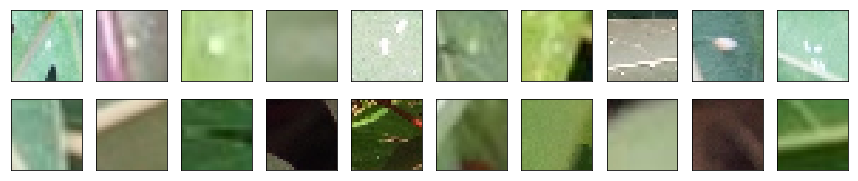

In [5]:
N_samples_to_display = 10
pos_indices = np.where(test_y)[0]
pos_indices = pos_indices[np.random.permutation(len(pos_indices))]
for i in range(N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_pos = test_X[pos_indices[i],:,:,:]
    example_pos = np.swapaxes(example_pos,0,2)
    plt.imshow(example_pos)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    


neg_indices = np.where(test_y==0)[0]
neg_indices = neg_indices[np.random.permutation(len(neg_indices))]
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.gcf().set_size_inches(1.5*N_samples_to_display,3)

## Training the CNN

We define our model:

Input layer

1. Convolution layer: 7 filters of size 3x3
2. Pooling layer: Max Pooling factor of 2
3. Convolution layer: 12 filters of size 2x2
4. Fully connected layer, with 500 hidden units

Output

In [5]:
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv2', layers.Conv2DLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
        
    input_shape=(None, 3, opts['patch_size'][0]/opts['image_downsample'], 
                 opts['patch_size'][0]/opts['image_downsample']),
    conv1_num_filters=7, 
    conv1_filter_size=(5, 5), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    conv2_num_filters=12, 
    conv2_filter_size=(2, 2),    
    conv2_nonlinearity=lasagne.nonlinearities.rectify,
        
    hidden3_num_units=500,
    output_num_units=2, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(500).fit(train_X, train_y)

# Neural Network with 488382 learnable parameters

## Layer information

  #  name     size
---  -------  -------
  0  input    3x25x25
  1  conv1    7x21x21
  2  pool1    7x10x10
  3  conv2    12x9x9
  4  hidden3  500
  5  output   2

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     0.61727     0.20801    2.96751      0.93961  80.42s
      2     0.19484     0.18322    1.06340      0.94786  101.54s
      3     0.17624     0.16896    1.04310      0.95259  82.93s
      4     0.16520     0.15992    1.03299      0.95480  79.90s
      5     0.15764     0.15164    1.03961      0.95668  85.89s
      6     0.15163     0.14585    1.03964      0.95758  79.29s
      7     0.14679     0.14330    1.02438      0.95874  79.22s
      8     0.14255     0.13901    1.02544      0.95953  79.26s
      9     0.13890     0.13666    1.01635      0.95960  79.31s
     10     0.13576     0.13306    1.02028      0.96054  79.36

    100     0.05657     0.09455    0.59824      0.97419  79.09s
    101     0.05620     0.09468    0.59362      0.97431  79.13s
    102     0.05582     0.09486    0.58843      0.97423  79.12s
    103     0.05543     0.09490    0.58409      0.97416  79.12s
    104     0.05505     0.09505    0.57917      0.97427  79.12s
    105     0.05470     0.09525    0.57424      0.97416  79.14s
    106     0.05432     0.09532    0.56988      0.97412  79.08s
    107     0.05397     0.09549    0.56522      0.97423  79.13s
    108     0.05358     0.09579    0.55940      0.97382  79.16s
    109     0.05323     0.09607    0.55411      0.97412  79.10s
    110     0.05287     0.09621    0.54951      0.97404  79.07s
    111     0.05249     0.09646    0.54420      0.97408  79.06s
    112     0.05213     0.09654    0.54002      0.97427  78.99s
    113     0.05178     0.09678    0.53500      0.97404  79.04s
    114     0.05143     0.09686    0.53094      0.97404  79.03s
    115     0.05103     0.09710    0.525

    213     0.02409     0.14055    0.17139      0.97243  79.06s
    214     0.02392     0.13970    0.17122      0.97236  79.00s
    215     0.02374     0.14093    0.16845      0.97243  79.03s
    216     0.02355     0.14161    0.16627      0.97247  79.07s
    217     0.02336     0.14112    0.16552      0.97243  79.05s
    218     0.02319     0.14130    0.16409      0.97239  79.18s
    219     0.02297     0.14246    0.16127      0.97232  79.17s
    220     0.02280     0.14328    0.15912      0.97269  79.10s
    221     0.02261     0.14367    0.15734      0.97254  79.15s
    222     0.02241     0.14397    0.15569      0.97247  79.15s
    223     0.02223     0.14396    0.15439      0.97251  79.13s
    224     0.02204     0.14435    0.15269      0.97254  79.12s
    225     0.02183     0.14504    0.15055      0.97266  79.11s
    226     0.02167     0.14604    0.14839      0.97236  79.00s
    227     0.02149     0.14640    0.14680      0.97251  79.04s
    228     0.02134     0.14665    0.145

    326     0.00947     0.21799    0.04343      0.96999  79.01s
    327     0.00943     0.21907    0.04305      0.96958  79.07s
    328     0.00932     0.21977    0.04243      0.96939  79.05s
    329     0.00926     0.22122    0.04186      0.96898  79.00s
    330     0.00917     0.22168    0.04136      0.96917  79.06s
    331     0.00910     0.22287    0.04081      0.96917  79.05s
    332     0.00903     0.22365    0.04036      0.96905  79.02s
    333     0.00891     0.22492    0.03961      0.96860  79.04s
    334     0.00886     0.22549    0.03931      0.96864  79.05s
    335     0.00879     0.22666    0.03877      0.96842  79.01s
    336     0.00872     0.22744    0.03833      0.96845  79.07s
    337     0.00863     0.22825    0.03781      0.96864  79.06s
    338     0.00858     0.22920    0.03745      0.96849  79.03s
    339     0.00851     0.23075    0.03686      0.96812  79.08s
    340     0.00845     0.23106    0.03657      0.96808  79.04s
    341     0.00839     0.23145    0.036

    440     0.00526     0.33212    0.01584      0.97123  80.01s
    441     0.00524     0.32961    0.01590      0.97131  79.93s
    442     0.00530     0.32666    0.01621      0.97071  79.92s
    443     0.00519     0.32474    0.01597      0.97097  79.87s
    444     0.00520     0.32506    0.01600      0.97059  80.16s
    445     0.00521     0.32352    0.01611      0.97003  80.09s
    446     0.00505     0.32332    0.01562      0.97071  80.22s
    447     0.00523     0.32479    0.01611      0.97026  83.80s
    448     0.00519     0.32839    0.01579      0.97097  86.08s
    449     0.00504     0.32771    0.01538      0.97097  87.03s
    450     0.00504     0.33044    0.01525      0.97071  86.94s
    451     0.00499     0.33131    0.01506      0.97074  86.82s
    452     0.00495     0.32768    0.01510      0.97033  88.68s
    453     0.00494     0.32992    0.01499      0.97063  87.78s
    454     0.00489     0.33098    0.01479      0.97022  87.82s
    455     0.00498     0.32436    0.015

## Make predictions and evaluate on test data

In [6]:
y_pred = cnn.predict_proba(test_X)

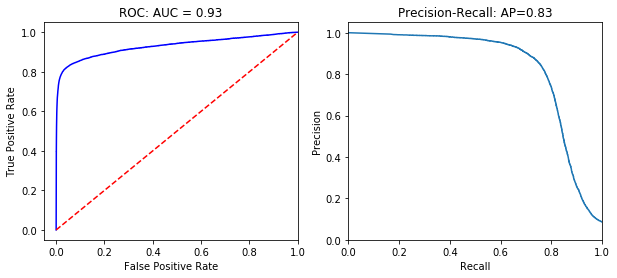

In [7]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

precision, recall, thresholds = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision = metrics.average_precision_score(test_y, y_pred[:, 1])

subplot(121)
plt.title('ROC: AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(122)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

plt.gcf().set_size_inches(10,4)

#plt.savefig('figs/plasmodium-patchevaluation.png', bbox_inches='tight')

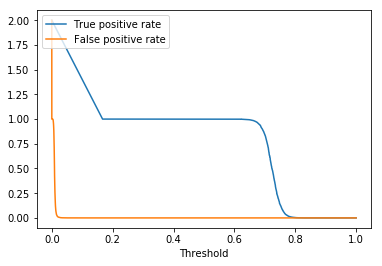

In [8]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
true_positive_rate.shape, thresholds.shape
plt.plot(true_positive_rate, thresholds,label='True positive rate')
plt.plot(false_positive_rate, thresholds, label='False positive rate')
plt.xlabel('Threshold')
plt.legend(loc='upper left')

## Examine mistakes to understand network performance: false positives.



###### Examine mistakes to understand network performance: false positives.



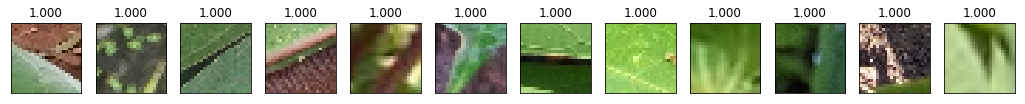

In [9]:
neg_indices = np.where(test_y==0)[0]
neg_scores = y_pred[neg_indices,1]
neg_indices = neg_indices[neg_scores.argsort()]
neg_indices = neg_indices[::-1]

neg_scores = y_pred[neg_indices,1]

N_samples_to_display = 12
offset = 55
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[neg_indices[i+offset],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % neg_scores[i+offset])
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('figs/whitefly-falsedetections.png', bbox_inches='tight')

###### See highest-scored test patches

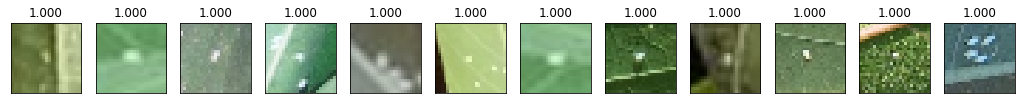

In [10]:
prob_range = [.95,1.]

tmp_scores = y_pred.copy()[:,1]
tmp_scores[tmp_scores<prob_range[0]] = -1
tmp_scores[tmp_scores>prob_range[1]] = -1

pos_indices = tmp_scores.argsort()
pos_indices = pos_indices[::-1]

N_samples_to_display = 12
offset = 0
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i+offset],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % (tmp_scores[pos_indices[i+offset]]))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('figs/whitefly-detectedpatches.png', bbox_inches='tight')



###### See lowest scored test patches

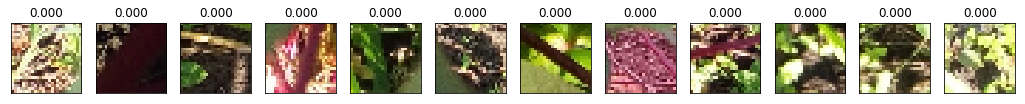

In [11]:
pos_indices = y_pred[:,1].argsort()

N_samples_to_display = 12

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % (y_pred[pos_indices[i],1]))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('figs/whitefly-testpatches-lowprob.png', bbox_inches='tight')



### Example of objects detected in an entire image 

##### The white boxes represent annotations in the training data. Red boxes are detections by the convnet.

/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):


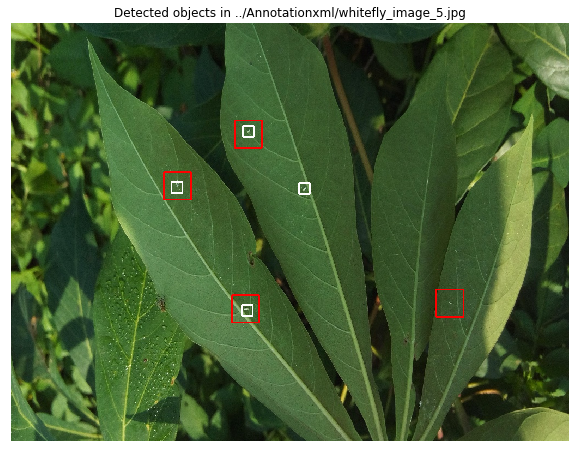

In [24]:
reload(det)

fname = testfiles[16]
imfile = opts['img_dir'] + fname
opts['detection_probability_threshold'] = 0.5
opts['detection_overlap_threshold'] = 0.1
found = det.detect(imfile, cnn, opts)

im = misc.imread(imfile)

plt.box(False)
plt.xticks([])
plt.yticks([])

annofile = opts['annotation_dir'] + fname[:-3] + 'xml'
bboxes = readdata.get_bounding_boxes_for_single_image(annofile)
for bb in bboxes:
    bb = bb.astype(int)
    cv2.rectangle(im, (bb[0],bb[2]), (bb[1],bb[3]), (255,255,255), 2)  

for f in found:
    f = f.astype(int)
    cv2.rectangle(im, (f[0],f[1]), (f[2],f[3]), (255,0,0), 2)

plt.gcf().set_size_inches(10,10)
plt.title('Detected objects in %s' % (imfile))
plt.imshow(im)

#cv2.imwrite('detectionimages/detected-' + os.path.basename(imfile),im)

## Saving the model

In [23]:
results = {
"false_positive_rate_CNN": false_positive_rate_CNN,
"true_positive_rate_CNN": true_positive_rate_CNN,
"precision_CNN": precision_CNN,
"average_precision_CNN": average_precision_CNN,
"opts": opts
}
import pickle
pickle.dump(results,open('whitefly-results.pkl','w'))